# Image Enhancement
__Quantitative Big Imaging__ ETHZ: 227-0966-00L

<p style="font-size:1em;">March 4, 2021</p>
<br /><br />
<p style="font-size:1.5em;padding-bottom: 0.25em;">Anders Kaestner</p>  
<p style="font-size:1em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>

## Todays lecture

- Imperfect images and noise
- Filters
- Advanced filters
- Evaluation workflows

### We need some modules

These modules are needed to run the python cells in this lecture.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import skimage.io as io
from skimage.morphology import disk
import scipy.ndimage as ndimage
import matplotlib        as mpl
mpl.rcParams['figure.dpi'] = 300

ModuleNotFoundError: No module named 'matplotlib'

# Measurements are rarely perfect
<figure><img src="figures/imperfect_imaging_system.svg" style="height:300px" align="middle"></figure>

There is no perfect measurement. This is also true for neutron imaging. The ideal image is the sample is distorted for many reasons. The figure below shows how an image of a sample can look after passing though the acquisition system. These quailty degradations will have an impact on the analysis of the image data. In some cases, it is possible to correct for some of these artifacts using classing image processing techniques. There are however also cases that require extra effort to correct the artifacts.  

```{figure} figures/imperfect_imaging_system.pdf
---
scale: 75%
---
Schematic showing the error contributions in an imperfect imaging system.
```

## Factors affecting the image quality

No measurement system is perfect and therefore, you will also not get perfect images of the sample you measured. In the figure you can see the slice as it would be in a perfect world to the left and what you actually would measure with an imaging system. Some are of higher quality than others but there are still a collection of factors that have an impact on the image quality.

The list below provides some factors that affect the quality of the acquired images. Most of them can be handled by changing the imaging configuration in some sense. It can however be that the sample or process observed put limitiations on how much the acquisition can be tuned to obtain the perfect image.

* Resolution (Imaging system transfer functions)
* Noise
* Contrast
* Inhomogeneous contrast
* Artifacts

### Resolution
The resolution is primarily determined optical transfer function of the imaging system. The actual resolution is given by the extents of the sample and how much the detector needs to capture in one image. This gives the field of view and given the number pixels in the used detector it is possible to calculate the pixel size. The pixel size limits the size of the smallest feature in the image that can be detected. The scintillator, which is used to convert neutrons into visible light, is chosen to 
1. match the sampling rate given by the pixel size.
2. provide sufficient neutron capture to obtain sufficient light output for a given exposure time.

### Noise
An imaging system has many noise sources, each with its own distribution e.g.
1. Neutron statistics - how many neutrons are collected in a pixel. This noise is Poisson distributed. 
2. Photon statistics - how many photons are produced by each neutron. This noise is also Poisson distributed.
3. Thermal noise from the electronics which has a Gaussian distribution.
4. Digitation noise from converting the charges collected for the photons into digital numbers that can be transfered and stored by a computer, this noise has a binominal distribution.

The neutron statistics are mostly dominant in neutron imaging but in some cases it could also be that the photon statistics play a role. 

### Contrast
The contrast in the sample is a consequence of 
1. how well the sample transmits the chosen radiation type. For neutrons you obtain good contrast from materials containing hydrogen or lithium while many metals are more transparent.
2. the amount of a specific element or material represented in a unit cell, e.g. a pixel (radiograph) or a voxel (tomography). 

The objective of many experiments is to quantify the amount of a specific material. This could for example be the amount of water in a porous medium.

Good contrast between different image features is important if you want to segment them to make conclusions about the image content. Therefore, the radiation type should be chosen to provide the best contrast between the features.

### Inhomogeneous contrast
The contrast in the raw radiograph depends much on the beam profile. These variations are easily corrected by normalizing the images by an open beam or flat field image. 

- __Biases introduced by scattering__ Scattering is the dominant interaction for many materials use in neutron imaging. This means that neutrons that are not passing straight though the sample are scattered and contribute to a background cloud of neutrons that build up a bias of neutron that are also detected and contribute to the 

- __Biases from beam hardening__ is a problem that is more present in x-ray imaging and is caused by that fact that the attenuation coefficient depends on the energy of the radiation. Higher energies have lower attenuation coefficient, thus will high energies penetrate the thicker samples than lower energies. This can be seen when a polychromatic beam is used. 

#### Artifacts
Many images suffer from outliers caused by stray rays hitting the detector. Typical artefacts in tomography data are
- Lines, which are caused by outlier spots that only appear in single projections. These spot appear as lines in the reconstructed images.
- Rings are caused by stuck pixels which have the same value in a projections.

## A typical processing chain

Traditionally, the processing of image data can be divided into a series of sub tasks that provide the final result.

```{figure} figures/image_proc_chain.pdf
---
scale: 100%
---
Typical steps of an image processing work flow.
```

* __Acquisition__ The data must obviously be acquired and stored. There are cases when simulated data is used. Then, the acquisition is replaced by the process to simulate the data.
* __Enhancement__ The raw data is usually not ready to be processed in the form is comes from the acquisition. It usually has noise and artifacts as we saw on the previous slide. The enhancement step suppresses unwanted information in the data.
* __Segmentation__ The segmenation identifies different regions based on different features such as intensity distribution and shape.
* __Post processing__ After segmentation, there may be falsely identified regions. These are removed in a post processing step. 
* __Evaluation__ The last step of the process is to make conclusions based on the image data. It could be modelling material distrbutions, measuring shapes etc.

<figure><img src="figures/image_proc_chain.svg" style="height:300px" align="middle"></figure>

Today's lecture will focus on __enhancement__

# Noise and artifacts

Noise is in very general terms for the unwanted information in a signal. More specifically, we are talking about random contributions that obscure the image information we are interested in.

## Noise types

Noise can have many different characteristics. In general, it is driven by a random distribution.

* Spatially uncorrelated noise

With spatially uncorrelated noise each pixel has a random value which is independend of the pixel neighborhood. This is also the easiest noise type to simulate.

* Event noise

The even noise has a random activation function that triggers the event of each pixel with some probabilty. This noise type produces spots randomly distributed over the image. The spots may also have a randomw intensity.

* Stuctured noise

The structured noise depends on the values of the pixel neighborhood and is thus spatially correlated. It is mostly driven by an uncorrelated noise source which is blurred by a weighted combination of the neighborhood.

The figure below shows examples of the three noise types.

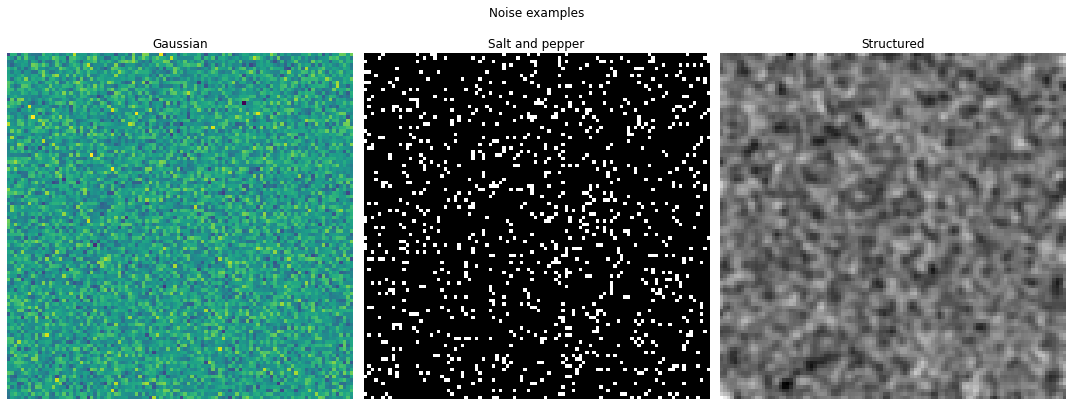

In [9]:
plt.figure(figsize=[15,6]);
plt.suptitle('Noise examples')
plt.subplot(1,3,1);plt.imshow(np.random.normal(0,1,[100,100])); plt.title('Gaussian');plt.axis('off');
plt.subplot(1,3,2);plt.imshow(0.90<np.random.uniform(0,1,size=[100,100]),cmap='gray'); plt.title("Salt and pepper"),plt.axis('off');
plt.subplot(1,3,3);plt.imshow(ski.filters.gaussian(np.random.normal(0,1,size=[100,100]),sigma=1),cmap='gray'); plt.title("Structured"),plt.axis('off');
plt.tight_layout();

### Noise models - Gaussian noise

Gaussian noise is the most common random distribution used. All other distributions asymptotically converges towards the Gaussian distribution thanks to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). The Gaussian noise is an easy distribution to work with when you derive signal processing models. This is also the reason why it is so popular to use this model also for non-Gaussian noise.

* Additive
* Easy to model 
* Law of large numbers

__Distribution function__

$$n(x)=\frac{1}{\sqrt{2\pi\sigma}}\exp{-\left(\frac{x-\mu}{2\sigma}\right)^2}$$

Below you see plots of the Gaussian distribution with different parameters.

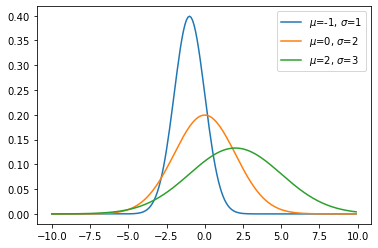

In [10]:
from scipy.stats import norm
rv = norm(loc = -1., scale = 1.0);rv1 = norm(loc = 0., scale = 2.0); rv2 = norm(loc = 2., scale = 3.0)
x = np.arange(-10, 10, .1)

#plot the pdfs of these normal distributions 
plt.plot(x, rv.pdf(x),label='$\mu$=-1, $\sigma$=1')
plt.plot(x, rv1.pdf(x),label='$\mu$=0, $\sigma$=2') 
plt.plot(x, rv2.pdf(x),label='$\mu$=2, $\sigma$=3')
plt.legend();

### Noise models - Poisson noise

The Poisson noise is the central noise model for event counting processes. It is thus the type of noise you see in imaging as the detectors in some sense is counting the number of particles arriving at the detector, e.g. photons or neutrons. This noise distribution changes shape with increasing number of particles; the distribution is clearly asymmetric for few particles while it takes a Gaussian shape when many particles are counted. It is also multiplicative in contrast to the Gaussian noise. This is in other words the noise distribution you need to use if you want to model image noise correctly.

* Multiplicative
* Physically correct for event counting

__Distribition function__ 

$$p(x)=\frac{\lambda^{k}}{k!} e^{-\lambda\,x}$$

The plot below show a poisson distribtion for $\lambda$=3

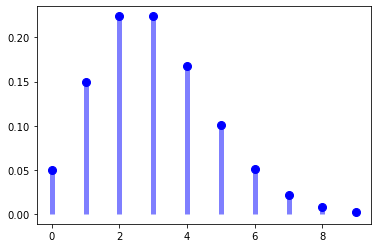

In [5]:
from scipy.stats import poisson
mu=3
fig, ax = plt.subplots(1, 1)
x = np.arange(poisson.ppf(0.01, mu),              poisson.ppf(0.999, mu))
ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5);

### Compare Gaussian and Possion noise

Now, let's compare relaizations of Gaussian and Poisson noise overlaid on a sine curve. The important thing to observe is that the noise amplitude is independent of the signal value and constant for the Gaussian noise. For Poisson noise it is very different. The noise amplitude changes with the signal values. Higher signal strength also produces greater noise amplitudes.

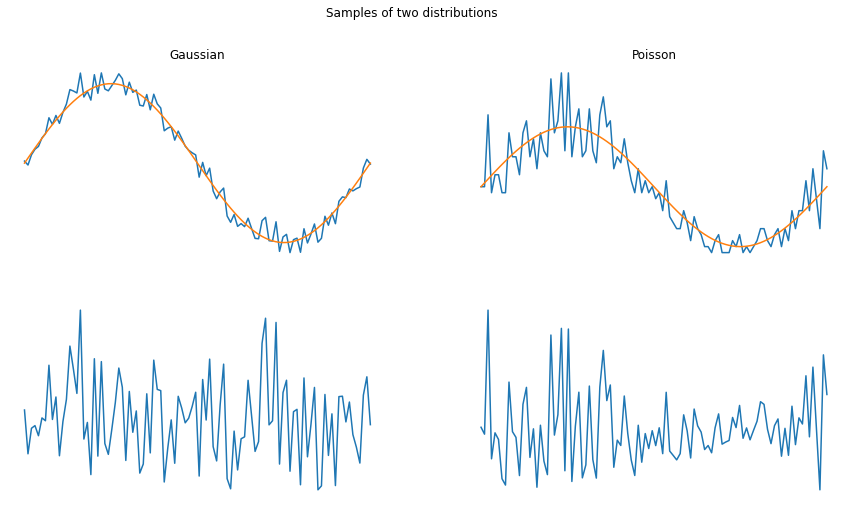

In [15]:
plt.figure(figsize=[15,8])
x=np.linspace(0,2*np.pi,100); 
y=10*np.sin(x)+11; ng=np.random.normal(0,1,size=len(x)); npoi = np.random.poisson(y);
plt.subplot(2,2,1); plt.plot(x,y+ng);plt.plot(x,y); plt.axis('off');plt.title('Gaussian'); plt.subplot(2,2,3);plt.plot(x,ng);plt.axis('off');
plt.subplot(2,2,2); plt.plot(x,npoi);plt.plot(x,y); plt.axis('off');plt.title('Poisson'); plt.subplot(2,2,4);plt.plot(x,npoi-y);plt.axis('off');
plt.suptitle('Samples of two distributions');

### Noise models - Salt'n'pepper noise
* A type of outlier noise
* Noise frequency described as probability of outlier
* Can be additive, multiplicative, and independent replacement

__Example model__
$$sp(x)=\left\{\begin{array}{ll}
-1 & x\leq\lambda_1\\ 
0 & \lambda_1< x \leq \lambda_2\\
1 & \lambda_2<x
\end{array}\right.\qquad \begin{array}{l}x\in\mathcal{U}(0,1)\\\lambda_1<\lambda_2\\
\lambda_1+\lambda_2 = \mbox{noise fraction}
\end{array}$$

### Salt'n'pepper examples

In [21]:
def snp(dims,Pblack,Pwhite) : # Noise model function
    uni=np.random.uniform(0,1,dims)
    img=(Pwhite<uni).astype(float)-(uni<Pblack).astype(float)
    return img

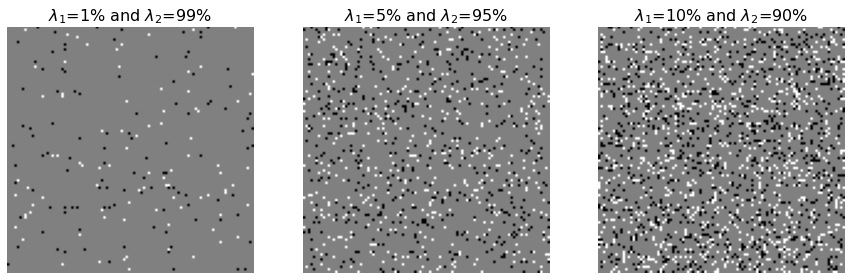

In [22]:
img10_90=snp([100,100],0.1,0.9); img5_95=snp([100,100],0.05,0.95);img1_99=snp([100,100],0.01,0.99)
plt.figure(figsize=[15,5])
plt.subplot(1,3,1); plt.imshow(img1_99,cmap='gray'); plt.title('$\lambda_1$=1% and $\lambda_2$=99%',fontsize=16); plt.axis('off');
plt.subplot(1,3,2); plt.imshow(img5_95,cmap='gray'); plt.title('$\lambda_1$=5% and $\lambda_2$=95%',fontsize=16); plt.axis('off');
plt.subplot(1,3,3); plt.imshow(img10_90,cmap='gray'); plt.title('$\lambda_1$=10% and $\lambda_2$=90%',fontsize=16); plt.axis('off');

## Signal to noise ratio

It is important to know how strong the noise is compared to the signal in order to decide how to proceed with the analysis. Therefore, we need a metric to quantify the noise. 

The Signal to noise ratio measures the noise strengh in a signal

__Definition__

$$SNR=\frac{mean(f)}{stddev(f)}$$

Sometimes the term contrast to noise ratio is also used. This means that you measure the intensity difference in between two relevant features and divide this by the noise.

### Signal to noise ratio for Poisson noise

The SNR of poisson noise is particularly easy to compute because $E[x]=v[x]$. This means that the SNR is proportional to the square root of the number of particles. 

- For a Poisson distribution the SNR is :

$$SNR=\frac{E[x]}{s[x]}\sim\frac{N}{\sqrt{N}}=\sqrt{N}$$

- $N$ is the number of particles $\sim$ exposure time

where _N_ is the number of captured particles. The figure below shows two neutron images acquired at 0.1s and 10s respectively. The plot shows the signal to noise ratio obtained for different exposure times.

The signal to noise ratio can be improved by increasing the number of neutrons per pixel. This can be achived through increasing
- Neutron flux - this is usually relatively hard as the neutron sources operate with the parameters it is designed for. There is a posibilty by changing the neutron aperture, but has an impact of the beam quality.
- Exposure time - the exposure time can be increased but in the end there is a limitation on how much this can be used. Beam time is limited which means the experiment must be finished in a given time. There is also an upper limit on the exposure time defined by the observed sample or process when it changes over time. Too long exposure times will result in motion artefacts.
- Pixel size - increasing the pixel size means that neutrons are collected over a greater area and thus more neutrons are captured during the exposure. The limit on how much you can increase the pixel size is defined by the smallest features you want to detect.
- Detector material and thickness - the number of captured neutrons depends on the scintillator material and how thick it is. The thickness does however have an impact on the resolution. Therefore scintillator thickness and pixel size often increase in parallel as there is no point in oversampling a smooth signal to much.

In the end, there are many parameters that combined results in the SNR you obtain. These parameters are tuned to match the experiment conditions. The filtering techniques presented in this lecture can help to increase the SNR and hopefuly make the way for a quantitaive analysis.

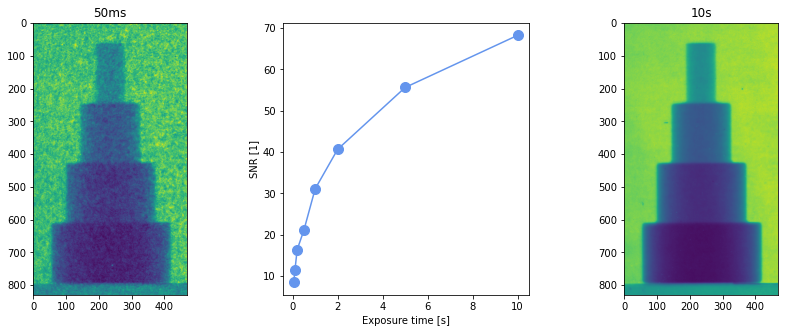

In [39]:
exptime=np.array([50,100,200,500,1000,2000,5000,10000])
snr = np.array([ 8.45949767, 11.40011621, 16.38118766, 21.12056507, 31.09116641,40.65323123, 55.60833117, 68.21108979]);
marker_style = dict(color='cornflowerblue', linestyle='-', marker='o',markersize=10, markerfacecoloralt='gray');
plt.figure(figsize=(15,5)) 
plt.subplot(1,3,2);plt.plot(exptime/1000,snr, **marker_style);plt.xlabel('Exposure time [s]');plt.ylabel('SNR [1]')
img50ms=plt.imread('figures//tower_50ms.png'); img10000ms=plt.imread('figures/tower_10000ms.png');
plt.subplot(1,3,1);plt.imshow(img50ms); plt.title('50ms'); plt.subplot(1,3,3); plt.imshow(img10000ms),plt.title('10s');

## Useful python functions

### Random number generators [numpy.random]
Generate an $m \times n$ random fields with different distributions:
* __Gauss__ ```np.random.normal(mu,sigma, size=[rows,cols])```
* __Uniform__ ```np.random.uniform(low,high,size=[rows,cols])```
* __Poisson__ ```np.random.poisson(lambda, size=[rows,cols])```
	
### Statistics

* ```np.mean(f)```, ```np.var(f)```, ```np.std(f)``` Computes the mean, variance, and standard deviation of an image $f$.
* ```np.min(f)```,```np.max(f)``` Finds minimum and maximum values in $f$.
* ```np.median(f)```, ```np.rank()``` Selects different values from the sorted data.


# Basic filtering

## What is a filter?

In general terms a filter is a component that separates mixed components form each other. In chemistry you use a filter to separate solid patricles from liquid. In signal processing the filter is used to separate frequencies in signals. In image processing we are not only talking about frequencies but also structures. This is something we will look into in a few weeks when we talk about morphological image processing.

### General definition
A filter is a processing unit that
* Enhances the wanted information 
* Suppresses the unwanted information

<div class="alert alert-block alert-warning">
Ideally without altering relevant features beyond recognition .
</div>

The filter should ideally perform the task it is meant to do, but at the same time maintain the information we want to keep. This is often a difficult problem, in particular with traditional filters. They apply the same characteristics to any pixel without concerning what this pixel actually represents. It only sees frequencies! As a consequence you may cancel all relevant information in the image in your mission to remove the noise.

## Filter characteristics

Filters are characterized by the type of information they suppress or amplify.

In signal and image processing filters are applied to modify the amplitudes of different frequencies in the signal. Slow variations have low frequencies while rapid variations have high frequencies.

### Low-pass filters

Low pass filters are designed to suppress frequencies in the upper part of the spectrum in order to better show slow changes in the images. The effect of a lowpass filter is that the images are blurred.

```{figure} figures/lp_principle.pdf
---
scale: 50%
---
The principle of a low-pass filter.
```

* Slow changes are enhanced 
* Rapid changes are suppressed 
<figure><img src="figures/lp_principle.svg" style="height:300px" align="middle"></figure>

### High-pass filters

High pass filters are the opposite of the low pass filters as the name suggests. The suppress low frequency components of the spectrum leaving the rapid changes untouched. This is an important filter for edge detection as we will see later.

```{figure} figures/hp_principle.pdf
---
scale: 50%
---
The principle of a high-pass filter.
```

* Rapid changes are enhanced 
* Slow changes are suppressed
<figure><img src="figures/hp_principle.svg" style="height:300px" align="middle"></figure>

# Basic filters

## Linear filters
Computed using the convolution operation

$$g(x)=h*f(x)=\int_{\Omega}f(x-\tau) h(\tau) d\tau$$
where

* __$f$__ is the image 
* __$h$__ is the convolution kernel of the filter

<figure><img src="figures/filter_box.svg" style="height:150px" align="middle"></figure>

## Low-pass filter kernels

The most common linear filters used in image processing are the box filter and the Gauss filter. The box filter has a kernel where all filter weights have the same strength. This filter essentially computes the local average of the neighborhood it covers. 
A 5x5 box filter looks like this

$$B=\frac{1}{25}\cdot\begin{array}{|c|c|c|c|c|}
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
\end{array}
$$ 

The scaling by the number of weights is sometimes omitted, but this would mean that the intensity of the resulting image is upscaled by this factor.

The Gauss filter kernel has its weights from the N-Dimensional Gauss function. Here, a 2D kernel:

$$G=\exp{-\frac{x^2+y^2}{2\sigma^2}}$$

The Gauss function is a continuous function that extends to infinity. Therefore, we have to define the size of the discrete kernel. A good choise is $N=2\cdot\lceil 2 \sigma \rceil+1$, multiple of $\sigma$ can also be set to 2.5 or even 3 but that is almost too much because the boundary weights are very small compared to the central value. 

```{figure} figures/gauss_bell.pdf
---
scale: 50%
---
The shape of a Gaussian filter kernel.
```

<table>
<tr style="bgcolor:#FFFFFF"><td>Mean or Box filter</td><td>Gauss filter</td></tr>
    
<tr><td>
   All weights have the same value.
</td><td>
    
$$G=\exp{-\frac{x^2+y^2}{2\,\sigma^2}}$$

</td></tr>
    
<tr><td>
    
Example:
$$B=\frac{1}{25}\cdot\begin{array}{|c|c|c|c|c|}
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
1 & 1 & 1 & 1& 1\\
\hline
\end{array}
$$   
    
</td>
<td>

Example:
<figure><img src="figures/gauss_bell.svg" style="height:300px" align="middle"></figure>       
</td></tr>    
</table>


<div class="alert alert-block alert-success">
<center>Low-pass filters suppress noise</center>
</div>

## Different SNR using a Gauss filter

The main purpose of lowpass filters is to reduce the noise in the images. In the following example you can see images with different SNR and what happens when you apply Gauss filters with different $\sigma$.

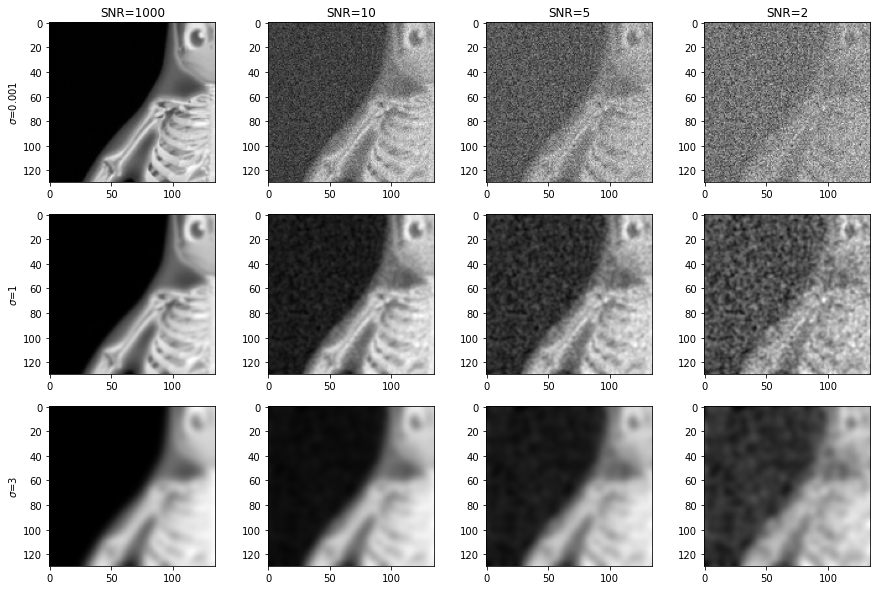

In [18]:
fig, ax = plt.subplots(3,4,figsize=(15,10)); ax=ax.ravel()
img   = plt.imread('figures/input_orig.png'); 
noise = np.random.normal(0,1,size=img.shape); 
SNRs   = [1000,10, 5, 2]
sigmas = [0.001,1,3]
for r,sigma in enumerate(sigmas) :
    for c,SNR in enumerate(SNRs) :
        ax[r*(len(SNRs))+c].imshow(ski.filters.gaussian(img+noise/SNR,sigma=sigma),cmap='gray');
    ax[r*(len(SNRs))].set_ylabel('$\sigma$={0}'.format(sigma))
for c,SNR in enumerate(SNRs) :
    ax[c].set_title('SNR={0}'.format(SNR))

What you see in the example is that you will need a wider filter kernel to reduce noise in images with low SNR. The cost of the SNR improvement is unfortunately that fine details in the image are also blurred by the operation. From this example we can conclude that linear filters can't be applied with out consequences for the image content. Therefore, we have to carefully select filter kernel balancing the improvement in SNR against loss of image features.

## How is the convolution computed

Before, we saw that the convolution was comouted using an integral. This is however the definition for continuous variables. In image processing, we change the integral into a sum instead. The convolution is then a weighted sum of the neighborhood pixels. The example below shows how a pixel is updated using a box kernel with the size 3x3. This operation is repeated for all pixels or voxels in the image.

```{figure} figures/principle_mean_filter.pdf
---
scale: 75%
---
Updating one pixel using a 3x3 box filter.
```

<figure><img src="figures/principle_mean_filter.svg" style="height:400px" align="middle"></figure>

<div class="alert alert-block alert-success">
For a non-uniform kernel each term is weighted by its kernel weight.
</div>

## Euclidean separability

The convolution involves quite many additions and multiplications to perform. This can be a bottleneck in a complicated processing workflow. Fortunately, some tricks can be used to recude the number of operations needed for the convolution.

The asociative and commutative laws apply to convoution

$$(a * b)*c=a*(b*c) \quad \mbox{ and } \quad a * b = b * a $$

A convolution kernel is called _separable_ if it can be split in two or more parts.

This is the case for the two filter kernels we have seen until now:

__Box__

$$\begin{array}{|c|c|c|}
\hline\cdot&\cdot&\cdot\\
\hline\cdot&\cdot&\cdot\\
\hline\cdot&\cdot&\cdot\\
\hline\end{array}=\begin{array}{|c|}\hline\cdot \\
\hline\cdot\\
\hline\cdot\\
\hline\end{array}*
\begin{array}{|c|c|c|}\hline\cdot&\cdot&\cdot\\\hline\end{array}$$
    
__Gauss__

$$\exp{-\frac{x^2+y^2}{2\sigma^2}}=\exp{-\frac{x^2}{2\sigma^2}}*\exp{-\frac{y^2}{2\sigma^2}}$$

### Gain of using separable kernels

Let's see what it brings to split the kernels in to the principal directions of the image. 

Separability reduces the number of computations $\rightarrow$ faster processing
- 3$\times$3 $\rightarrow$ 9 mult and 8 add $\Leftrightarrow$ 6 mult and 4 add
- 3$\times$3$\times$3 $\rightarrow$ 27 mult and 26 add $\Leftrightarrow$ 9 mult and 6 add

The gain is moderate in the 3x3 three case, but if we increase the kernel size to 5 instead we see that the gain is increasing radically:
- 5$\times$5 $\rightarrow$ 25 mult and 24 add $\Leftrightarrow$ 10 mult and 8 add
- 5$\times$5$\times$5 $\rightarrow$ 125 mult and 124 add $\Leftrightarrow$ 15 mult and 12 add

This looks very promising and it would be great. There are however some things to consider:
- Overhead to call the filter function may consume some of the time gain from the separability.
- The result may deviate a little depending on the used numerical precision used. 

## The median filter

The median filter is a non-linear filter with low-pass characteristics. This filter computes the local median using the pixels in the neighborhood and uses this value in the filtered image. 

```{figure} figures/principle_median_filter.pdf
---
scale: 75%
---
Updating a pixel from its neighborhood using a 3x3 median filter.
```

<figure><img src="figures/principle_median_filter.svg" style="height:400px" align="middle"></figure>

## Comparing filters for different noise types

Both linear low-pass filters and the median filter have SNR improving charactersitics. They do, however, differ in which noise types they are suited for. In the example below you see an image with add Gaussian noise and salt'n'pepper noise. 

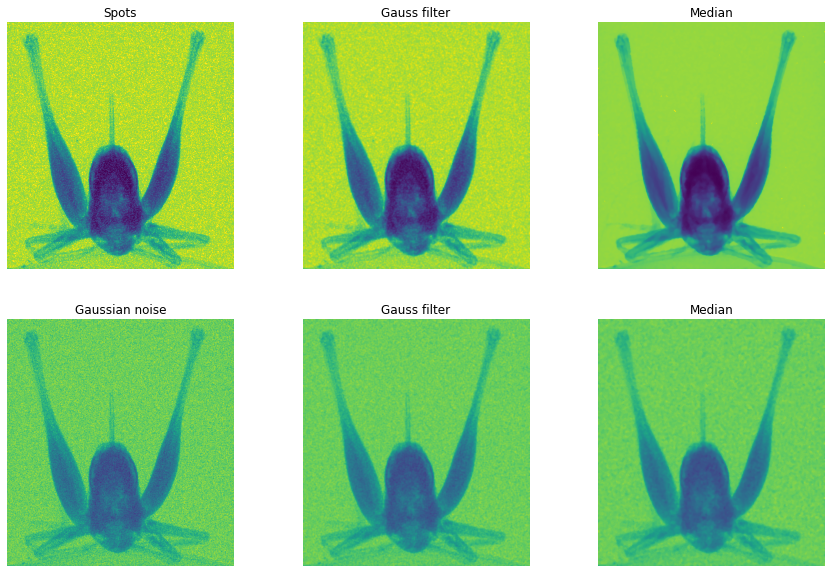

In [30]:
img = plt.imread('figures/grasshopper.png'); noise=img+np.random.normal(0,0.1,size=img.shape); spots=img+0.2*snp(img.shape,0,0.8); noise=(noise-noise.min())/(noise.max()-noise.min());spots=(spots-spots.min())/(spots.max()-spots.min());
plt.figure(figsize=[15,10]); vmin=0.0; vmax=0.9;
plt.subplot(2,3,1); plt.imshow(spots,vmin=vmin,vmax=vmax); plt.title('Spots'); plt.axis('off');
plt.subplot(2,3,2); plt.imshow(ski.filters.gaussian(spots,sigma=1),vmin=vmin,vmax=vmax); plt.title('Gauss filter'); plt.axis('off');
plt.subplot(2,3,3); plt.imshow(ski.filters.median(spots,disk(3)),vmin=vmin,vmax=vmax); plt.title('Median'); plt.axis('off');

plt.subplot(2,3,4); plt.imshow(noise,vmin=vmin,vmax=vmax); plt.title('Gaussian noise'); plt.axis('off');
plt.subplot(2,3,5); plt.imshow(ski.filters.gaussian(noise,sigma=1),vmin=vmin,vmax=vmax); plt.title('Gauss filter'); plt.axis('off');
plt.subplot(2,3,6); plt.imshow(ski.filters.median(noise,disk(3)),vmin=vmin,vmax=vmax); plt.title('Median'); plt.axis('off');

In this comparison, you can clearly see that the median filter is supperior when it comes to remove outliers in an image. In this case, the Gauss filter is only smearing out the outliers, but they still appear as noisy. 

In the case of Gaussian noise, it is harder to tell which filter to use. Many are using the median filter as their main goto choise to filter images. Because it is usually gentler to edges and is also good at removing spots. Still, you should be aware of the additional processing time and also that the statistical distribution of the data is not following the original model anymore. The distribution of the data may not be of any concern in many cases, but if you are trying to process the image further based on its distribution, this may result in less good results.

## Filter example: Spot cleaning

```{figure} figures/spotty_knot_closeup.png
---
scale: 50%
---
A neutron image with outliers that we want to remove.
```

<table>
<tr><th width="45%">Problem</th><th width="20%">Example</th><th width="35%">Possible solutions</th></tr>
<tr><td>
        
- Many neutron images are corrupted by spots that confuse following processing steps. 
- The amount, size, and intensity varies with many factors.   

</td>
<td>
<figure><img src="figures/spotty_knot_closeup.png" style="height:300px" align="middle"></figure>   
</td>
<td>
    
- Low pass filter
- Median filter
- Detect spots and replace by estimate

</td></tr>
</table>

## Spot cleaning algorithm

```{figure} figures/spotclean_algorithm.pdf
---
scale: 100%
---
Process workflow to selectively remove spots from an image.
```

<figure><img src="figures/spotclean_algorithm.svg" style="height:400px" align="middle"></figure>

__Parameters__

- $N$ Width of median filter.
- $k$ Threshold level for outlier detection.

## Spot cleaning - Compare performance

```{figure} figures/spotclean_compare.pdf
---
scale: 100%
---
Comparing different filters to remove spots from an image.
```

<figure><img src="figures/spotclean_compare.svg"  style="height:500px" align="middle"></figure>

### The ImageJ ways for outlier removal

ImageJ is a popular application for interactive image analysis. It offers two ways to remove outliers in the noise menu:

- __Despeckle__ Median ... please avoid this one!!!
- __Remove outliers__ Similar to cleaning described algorithm

## High-pass filters
High-pass filters enhance rapid changes $\rightarrow$ ideal for edge detection

### Typical high-pass filters:

#### Gradients
$$\frac{\partial}{\partial x}=\frac{1}{2}\cdot\begin{array}{|c|c|}
\hline
-1 & 1\\
\hline
\end{array}\qquad
\frac{\partial}{\partial x}=\frac{1}{32}\cdot\begin{array}{|c|c|c|}
\hline
-3 & 0 & 3\\
\hline
-10 & 0 & 10\\
\hline
-3 & 0 & 3\\
\hline
\end{array}
$$
#### Laplacian
$$
\bigtriangleup=\frac{1}{2}\cdot\begin{array}{|c|c|c|}
\hline
1 & 2 & 1\\
\hline
2 & -12 & 2\\
\hline
1 & 2 & 1\\
\hline
\end{array}
$$
#### Sobel
$$
G=|\nabla f|=\sqrt{\left(\frac{\partial}{\partial x}f\right)^2 + \left(\frac{\partial}{\partial y}f\right)^2}
$$


## Gradient example

#### Vertical edges
$\frac{\partial}{\partial x}=\frac{1}{32}\cdot\begin{array}{|c|c|c|}
\hline
-3 & 0 & 3\\
\hline
-10 & 0 & 10\\
\hline
-3 & 0 & 3\\
\hline
\end{array}$  

#### Horizontal egdges
$\frac{\partial}{\partial\,y}=\frac{1}{32}\cdot\begin{array}{|c|c|c|}
\hline
-3 & -10 & -3\\
\hline
0 & 0 & 0\\
\hline
3 & 10 & 3\\
\hline
\end{array}$

[Jaehne, 2005](https://doi.org/10.1007/3-540-27563-0)

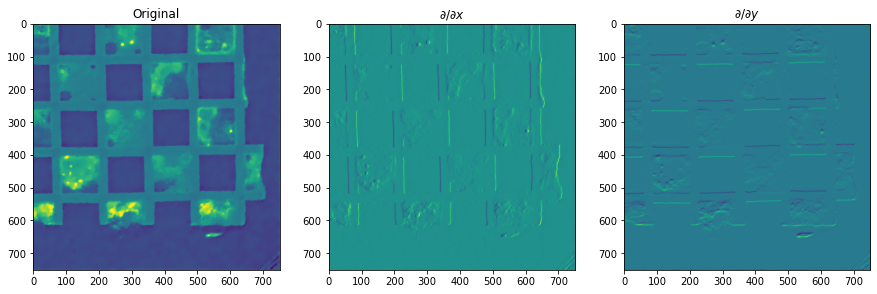

In [35]:
img=plt.imread('figures/orig.png')
k = np.array([[-3,-10,-3],[0,0,0],[3,10,3]]);
plt.figure(figsize=[15,8])
plt.subplot(1,3,1); plt.imshow(img);plt.title('Original');
plt.subplot(1,3,2); plt.imshow(ndimage.convolve(img,np.transpose(k)));plt.title('$\partial / \partial x$');
plt.subplot(1,3,3); plt.imshow(ndimage.convolve(img,k));plt.title('$\partial / \partial y$');

## Edge detection examples

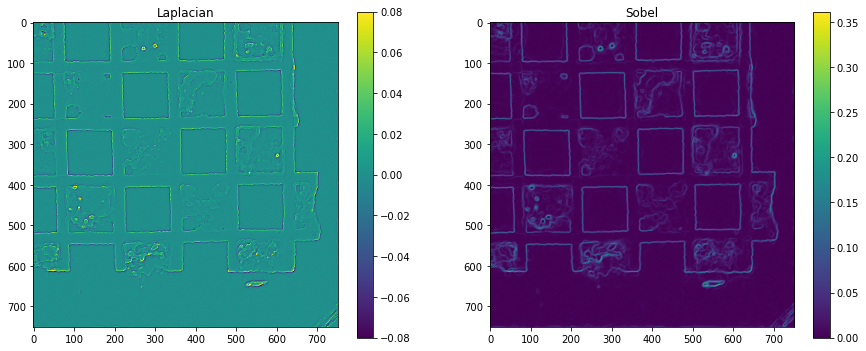

In [27]:
img=plt.imread('figures/orig.png');
plt.figure(figsize=[15,6])
plt.subplot(1,2,1);plt.imshow(ski.filters.laplace(img),clim=[-0.08,0.08]); plt.title('Laplacian'); plt.colorbar();
plt.subplot(1,2,2);plt.imshow(ski.filters.sobel(img)); plt.title('Sobel');  plt.colorbar();

## Relevance of filters to machine learning

```{figure} figures/convolutional_neural_network.png
---
scale: 80%
---
An example of a convolutional neural network for image classification.
```

<center><img src="figures/convolutional_neural_network.png"  style="height:500px" align="middle"></center>
	
[NVIDIA Developer zone](https://developer.nvidia.com/discover/convolutional-neural-network)

# Frequency space filters

We already mentioned that the there are frequencies to filter in images. There is a whole collection of filters that operate directly in frequency space. This is mostly done using the Fourier transform and its inverse.  

## Applications of the Fourier transform

## The Fourier transform

You may only know the Fourier transform for the 1D case. It is however very easy to increase the number of dimensions. Below you see the 2D Fourier transform and its inverse. These operations are lossless one-to-one, meaning you can go from one domain to the other without loosing any information.

__Transform__

$$G(\xi_1,\xi_2)=\mathcal{F}\{g\}=\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} g(x,y)
\exp{-i(\xi_1 x+\xi_2 y)}\,dx\,dy$$

__Inverse__

$$ g(x,y)=\mathcal{F}^{-1}\{G\}=\frac{1}{(2\,\pi)^2}\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} G(\omega)
\exp{i(\xi_1 x+\xi_2 y)} d\xi_1 d\xi_2$$

### FFT (Fast Fourier Transform)

The previous equations are meant for continuous signals. Images are discrete signals and the integrals turn into sums. This may introduce some numerical losses when the transforms are computed. Computing the DFT is an $O(N^2)$ operation. There is a way to speed this up by using the Fast Fourier Transform algorithm. This algorithm requires that the data has the length $N=2^k$. In this case the complexity reduces to $O(N\cdot\log(N))$, which is a radical speed-up.

In practice - you never see the transform equations. 
The Fast Fourier Transform algorithm is available in numerical libraries and tools.

[Jaehne, 2005](https://doi.org/10.1007/3-540-27563-0)

## Some mathematical features of the FT
### Additition

Addition of Fourier spectra works the same way as for real space signal. The reason is that the transform is based on summarions. You probably proved this as an exercise in your math classes. The plots below shows the spectra of the sum of two signals.  

$\mathcal{F}\{a+b\} = \mathcal{F}\{a\}+\mathcal{F}\{b\}$

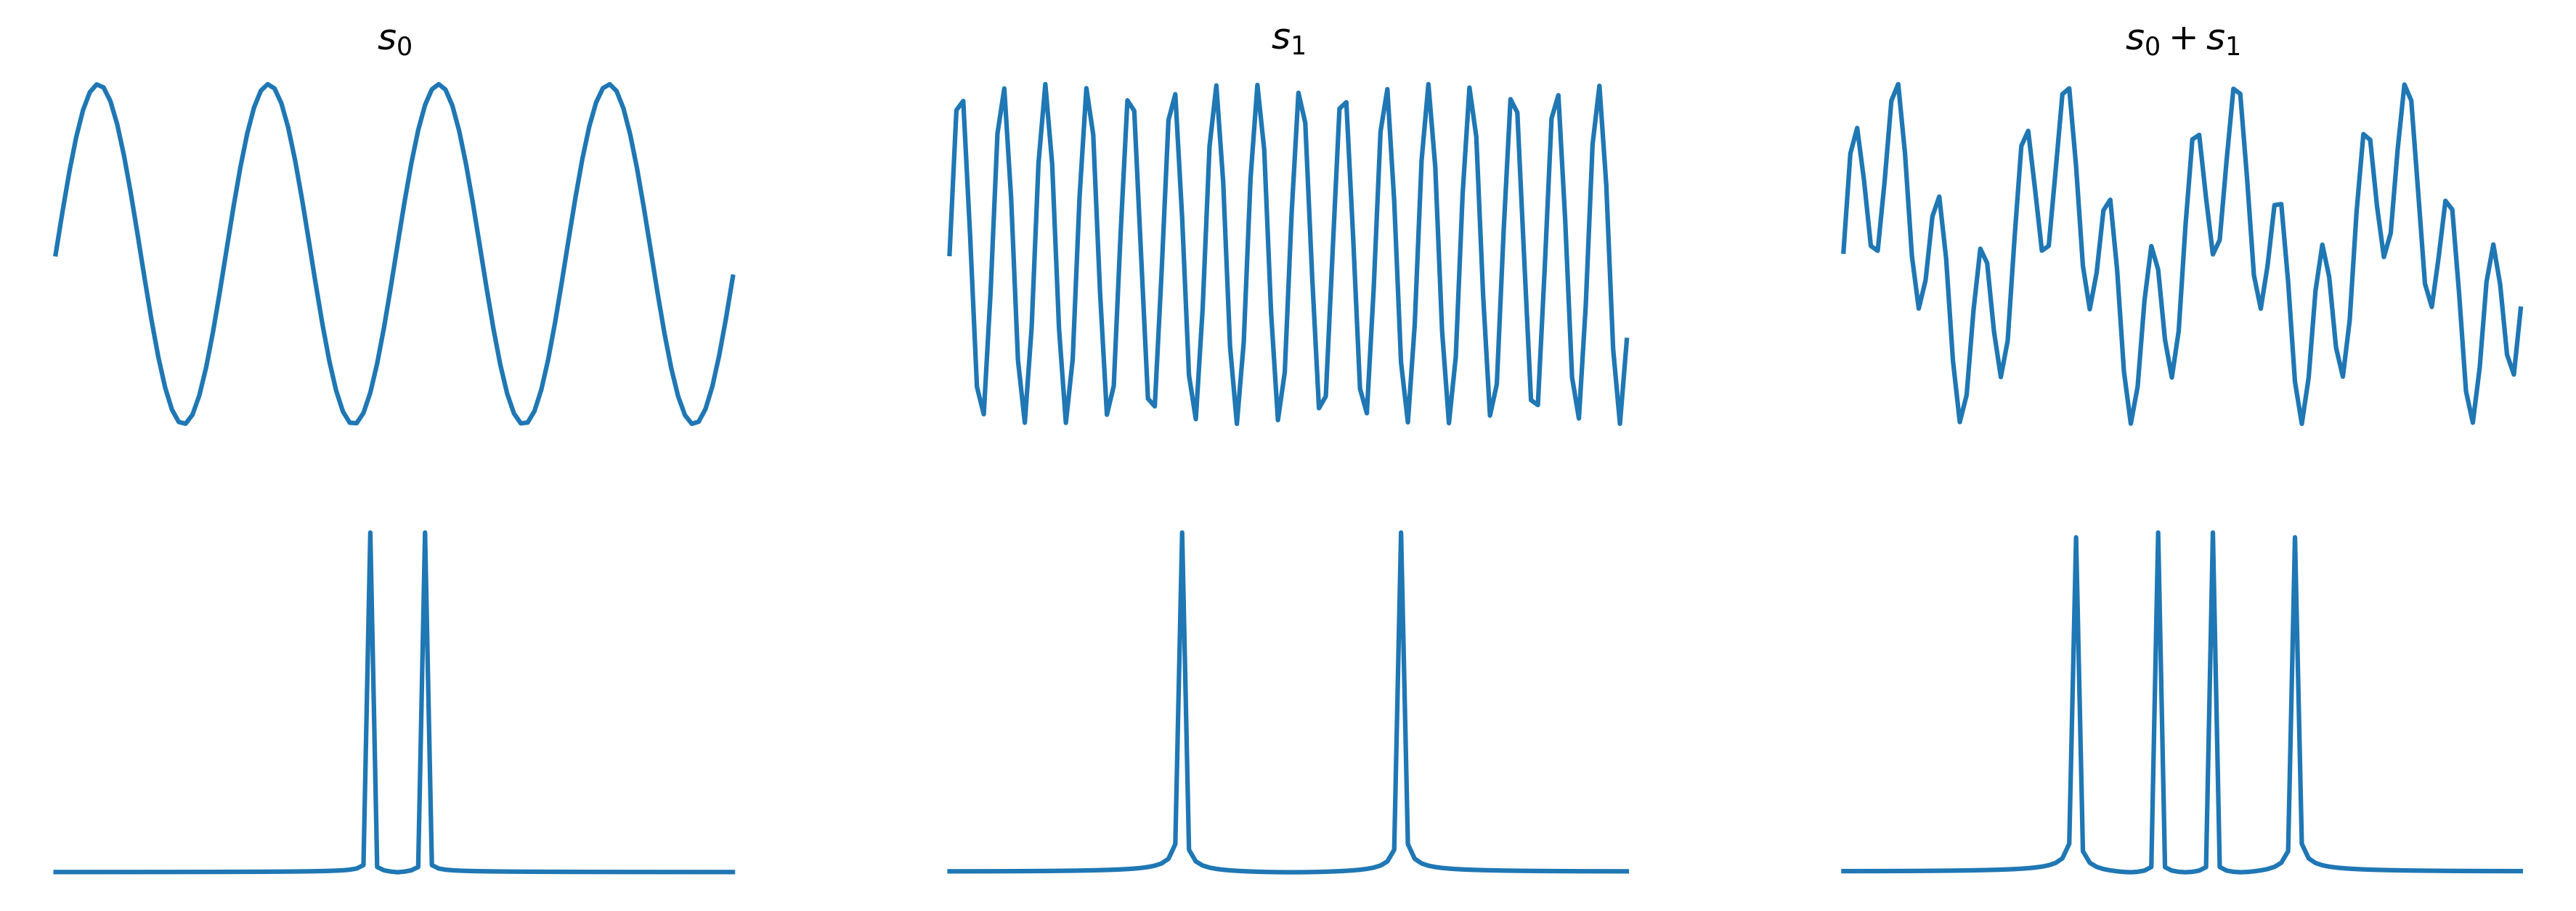

In [4]:
x = np.linspace(0,50,100); s0=np.sin(0.5*x); s1=np.sin(2*x);
plt.figure(figsize=[15,5])
plt.subplot(2,3,1);plt.plot(x,s0); plt.axis('off');plt.title('$s_0$');plt.subplot(2,3,4);plt.plot(np.abs(np.fft.fftshift(np.fft.fft(s0))));plt.axis('off');
plt.subplot(2,3,2);plt.plot(x,s1); plt.axis('off');plt.title('$s_1$');plt.subplot(2,3,5);plt.plot(np.abs(np.fft.fftshift(np.fft.fft(s1))));plt.axis('off');
plt.subplot(2,3,3);plt.plot(x,s0+s1); plt.axis('off');plt.title('$s_0+s_1$');plt.subplot(2,3,6);plt.plot(np.abs(np.fft.fftshift(np.fft.fft(s0+s1))));plt.axis('off');

### Convolution

Convolution, which is a relatively intense task to perform in real space reduces to a frequency-wise multiplication in the Fourier space. This is a very useful property of the transform. It allows to design some filters much easier than in real space. In particular, band stop filters to remove a specific feature in the image. Also filters with wide kernels can be faster to compute using the Fourier transform.

$\mathcal{F}\{a * b\} = \mathcal{F}\{a\} \cdot \mathcal{F}\{b\} $
$\mathcal{F}\{a \cdot b\} = \mathcal{F}\{a\} * \mathcal{F}\{b\} $

## Additive noise in Fourier space
#### Real space

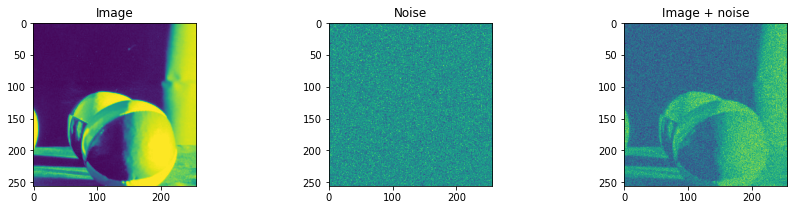

In [30]:
img=plt.imread('figures/bp_ex_original.png'); noise=np.random.normal(0,0.2,size=img.shape); nimg=img+noise;
plt.figure(figsize=[15,3])
plt.subplot(1,3,1); plt.imshow(img);plt.title('Image');
plt.subplot(1,3,2); plt.imshow(noise);plt.title('Noise');
plt.subplot(1,3,3); plt.imshow(nimg);plt.title('Image + noise');

#### Fourier space

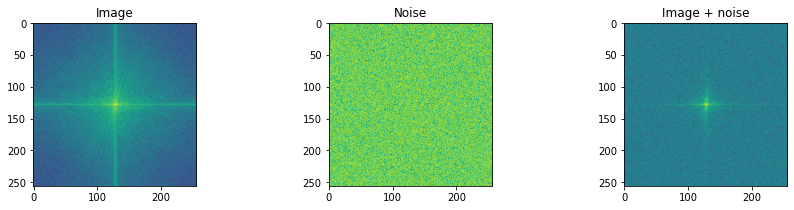

In [31]:
plt.figure(figsize=[15,3])
plt.subplot(1,3,1); plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(img)))));plt.title('Image');
plt.subplot(1,3,2); plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(noise)))));plt.title('Noise');
plt.subplot(1,3,3); plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(nimg)))));plt.title('Image + noise');

### Problem
How can we suppress noise without destroying relevant image features?

## Spatial frequencies and orientation

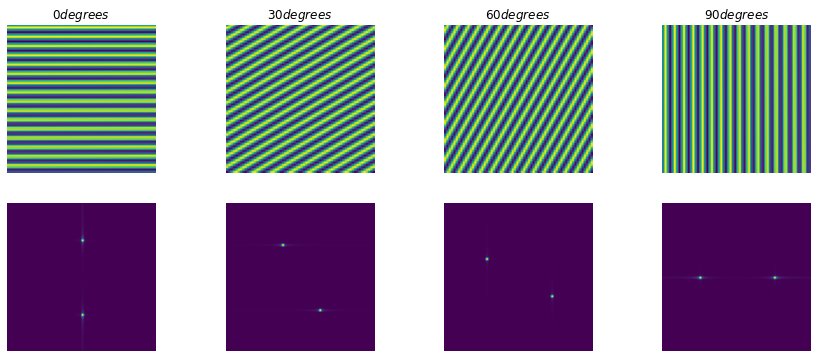

In [37]:
def ripple(size=128,angle=0,w0=0.1) :
    w=w0*np.linspace(0,1,size);
    [x,y]=np.meshgrid(w,w);
    img=np.sin((np.sin(angle)*x)+(np.cos(angle)*y));
    return img
N=64;
fig, ax = plt.subplots(2,4, figsize=(15,6)); ax=ax.ravel()

for idx,angle in enumerate([0,30,60,90]) :
    d=ripple(N,angle=(angle+0.1)/180*np.pi,w0=100);
    ax[idx].imshow(d); ax[idx].set_title('${0} degrees$'.format(angle)); ax[idx].axis('off');
    ax[idx+4].imshow((np.abs(np.fft.fftshift(np.fft.fft2(d)))));   ax[idx+4].axis('off');

## Example - Stripe removal in Fourier space

- Transform the image to Fourier space
$$\mathcal{F_{2D}}\left\{a\right\} \Rightarrow A$$

- Multiply spectrum image by band pass filter
$$A_{filtered}=A \cdot H$$

- Compute the inverse transform to obtain the filtered image in real space
$$\mathcal{{F_{2D}}^{-1}}\left\{A_{filtered}\right\} \Rightarrow a_{filtered}$$

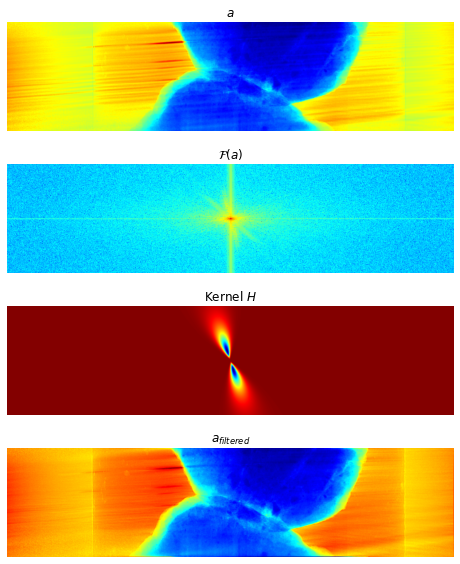

In [38]:
plt.figure(figsize=[8,10])
plt.subplot(4,1,1);plt.imshow(plt.imread('figures/raw_img.png')); plt.title('$a$'); plt.axis('off');
plt.subplot(4,1,2);plt.imshow(plt.imread('figures/raw_spec.png')); plt.title('$\mathcal{F}(a)$'); plt.axis('off');
plt.subplot(4,1,3);plt.imshow(plt.imread('figures/filt_spec.png')); plt.title('Kernel $H$'); plt.axis('off');
plt.subplot(4,1,4);plt.imshow(plt.imread('figures/filt_img.png')); plt.title('$a_{filtered}$'); plt.axis('off');

## The effect of the stripe filter

```{figure} figures/slice_with_stripes.png
---
scale: 50%
---
CT slice before stripe removal filter.
```
```{figure} figures/slice_stripe_filtered.png
---
scale: 50%
---
CT slice after applying stripe removal filter.
```

<table><tr><td> Reconstructed CT slice before filter</td><td>Reconstructed CT slice after stripe filter</td></tr>
    <tr>
        <td><img src="figures/slice_with_stripes.png"  style="height:400px" align="middle"></td>
        <td><img src="figures/slice_stripe_filtered.png"  style="height:400px" align="middle"></td>
    <tr>
</table>

Intensity variations are suppressed using the stripe filter on all projections.

## Technical details on Fourier space filters
#### When should you use convolution in Fourier space?
-  Simplicity
-  Kernel size
-  Speed at repeated convolutions

#### Zero padding
The FFT is only working with data of size in $2^N$. If your data has a different length, you have to pad (fill with constant value) up the next $2^N$.

## Python functions
	
#### Filters in the spatial domain
e.g. from ```scipy import ndimage```
- ```ndimage.filters.convolve(f,h)``` Linear filter using kernel $h$ on image $f$.
- ```ndimage.filters.median_filter(f,\[n,m\])```  Median filter using an $n \times m$ filter neighborhood

#### Fourier transform
- ```np.fft.fft2(f)``` Computes the 2D Fast Fourier Transform of image $f$
- ```np.fft.ifft2(F)``` Computes the inverse Fast Fourier Transform $F$.
- ```np.fft.fftshift()``` Rearranges the data to center the $\omega$=0. Works for 1D and 2D.

#### Complex numbers
- ```np.abs(f), np.angle(f)``` Computes amplitude and argument of a complex number.
- ```np.real(f), np.imag(f)``` Gives the real and imaginary parts of a complex number.

# Scale spaces

## Why scale spaces?

### Motivation
Basic filters have problems to handle low SNR and textured noise.

Something new is required...
### The solution
Filtering on different scales can take noise suppression one step further.

```{figure} figures/burt_pyramid.pdf
---
scale: 75%
---
A scale pyramid of an image can be useful for filtering and segmentation.
```

<center><img src="figures/burt_pyramid.svg"  style="height:400px" align="middle"></center>

## Wavelets - the basic idea
- The wavelet transform produces scales by decomposing a signal into two signals at a coarser scale containing \emph{trend} and \emph{details}.\\
- The next scale is computed using the trend of the previous transform

$$WT\{s\}\rightarrow\{a_1,d_1\}, WT\{a_1\}\rightarrow\{a_2,d_2\}, \ldots, WT\{a_{N-1}\}\rightarrow\{a_N,d_N\} $$

- The inverse transform brings $s$ back using $\{a_N,d_1, \ldots,d_N\}$.
- Many wavelet bases exists, the choice depends on the application.

### Applications of wavelets  
- Noise reduction 
- Analysis 
- Segmentation
- Compression
    
[Walker 2008](https://doi.org/10.1201/9781584887461) [Mallat 2009](https://doi.org/10.1016/B978-0-12-374370-1.X0001-8)

## Wavelet transform of a 1D signal

```{figure} figures/wavelet1d_noaxis.pdf
---
scale: 60%
---
A noisy test signal decomposed using the _symlet-4_ wavelet base function.
```

<center><img src="figures/wavelet1d_noaxis.svg" style="height:400px"></center>

Using __symlet-4__

## Wavelet transform of an image

```{figure} figures/wt2d_schematic.pdf
---
scale: 80%
---
Transform workflow for a 2D wavelet decomposition.
```

<center><img src="figures/wt2d_schematic.svg" style="height:400px"></center>

## Wavelet transform of an image - example

```{figure} figures/testpattern_1024.png
---
scale: 40%
---
Transform workflow for a 2D wavelet decomposition.
```

```{figure} figures/wt_testimage_gray.png
---
scale: 40%
---
Transform workflow for a 2D wavelet decomposition.
```

<table><tr><th>Original</th><th>Wavelet transformed</th></tr>
<tr>
    <td><img src="figures/testpattern_1024.png" style="height:400px"></td>
    <td><img src="figures/wt_testimage_gray.png" style="height:400px"></td>
</tr>
</table>

## Using wavelets for noise reduction
The noise is found in the detail part of the WT
-  Make a WT of the signal to a level that corresponds to the scale of the unwanted information.
- Threshold the detail part $d_{\gamma}=|d|<\gamma\quad ? \quad 0 : d$.
- Inverse WT back to normal scale $\rightarrow$ image is filtered.

```{figure} figures/wavelet1d_filter.pdf
---
scale: 100%
---
The principle of a basic noise reduction filter using wavelets.
```

<center><img src="figures/wavelet1d_filter.svg" style="height:400px"></center>

## Wavelet noise reduction - Image example

Example Filtered using two levels of the Symlet-2 wavelet

```{figure} figures/wavelet2d_filtered.pdf
---
scale: 100%
---
An example of noise reduction using a wavelet filter.
```

__Data:__ Neutron CT of a lead scroll
<center><img src="figures/wavelet2d_filtered.svg" style="height:400px"></center>

## Python functions for wavelets
- __dwt2__/__idtw2__ Makes one level of the wavelet transform or its inverse using wavelet base specified by 'wn'. 
- __wavedec2__ Performs N levels of wavelet decomposition using a specified wavelet base.
- __wbmpen__ Estimating threshold parameters for wavelet denoising.
- __wdencmp__ Wavelet denoising and compression using information from *wavedec2* and *wbmpen.


# Parameterized scale spaces

## PDE based scale space filters

```{figure} figures/slice_original.pdf
---
scale: 50%
---
Noisy slice to be filtered.
```

```{figure} figures/slice_diffusion.pdf
---
scale: 50%
---
Slice after diffusion filter.
```

```{figure} figures/slice_iss.pdf
---
scale: 50%
---
Slice after ISS filter.
```

<table><tr>
    <td><img src="figures/slice_original.svg"  style="height:300px"></td>
    <td><img src="figures/slice_diffusion.svg" style="height:300px"></td>
    <td><img src="figures/slice_iss.svg"       style="height:300px"></td>
</tr></table>

These filters may work for applications where Linear and Rank filters fail.

[Aubert 2002](https://doi.org/10.1007/978-0-387-44588-5).

## The starting point
The heat transport equation
$$\frac{\partial T}{\partial t}=\kappa \nabla^2 T$$

- __$T$__ Image to filter (intensity $\equiv$ temperature)
- __$\kappa$__ Thermal conduction capacity
<table>
    <tr><td>Original</td><td>Iterations</td></tr>
    <tr>
          <td><img src="figures/lindif_iter.png" style="height:200px"></td>
          <td><video src="movies/lindif_iter.mp4" type="video/mp4" controls autoplay loop height="200px"></td>
    </tr>
    </table>

<div class="alert alert-block alert-warning">
<center>The steady state solution is a homogeneous image...</center>
</div>



## Controlling the diffusivity

In [32]:
def g(x,lambd,n) :
    g=1/(1+(x/lambd)**n)
    return g

We want to control the diffusion process...

- _Near edges_ The Diffusivity $\rightarrow$ 0
- _Flat regions_ The Diffusivity $\rightarrow$ 1

The contrast function $G$ is our control function
$$G(x)=\frac{1}{1+\left(\frac{x}{\lambda}\right)^n}$$

- _$\lambda$_ Threshold level
- _$n$_ Steepness of the threshold function

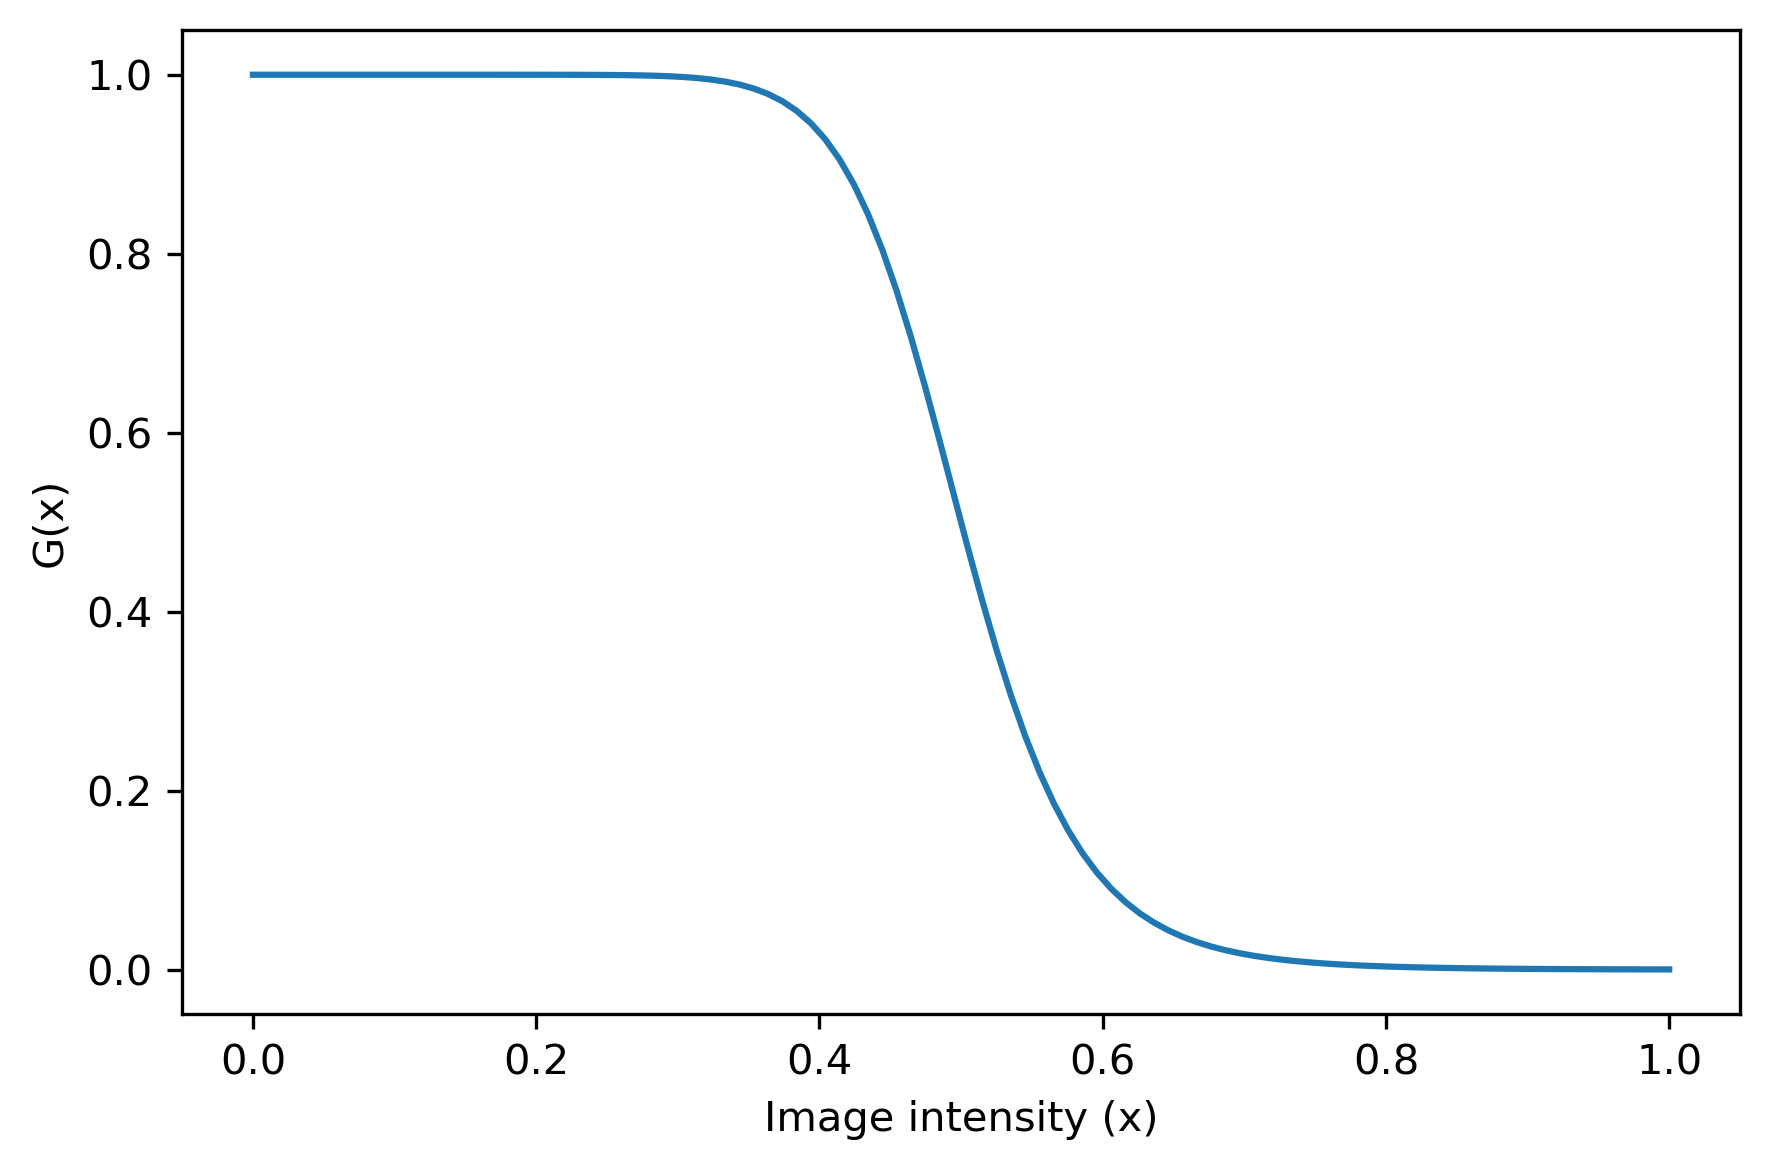

In [37]:
x=np.linspace(0,1,100);

plt.plot(x,g(x,lambd=0.5,n=12));
plt.xlabel('Image intensity (x)'); plt.ylabel('G(x)');plt.tight_layout()

## Gradient controlled diffusivity

$$\frac{\partial u}{\partial t}=G(|\nabla u|)\nabla^2 u$$

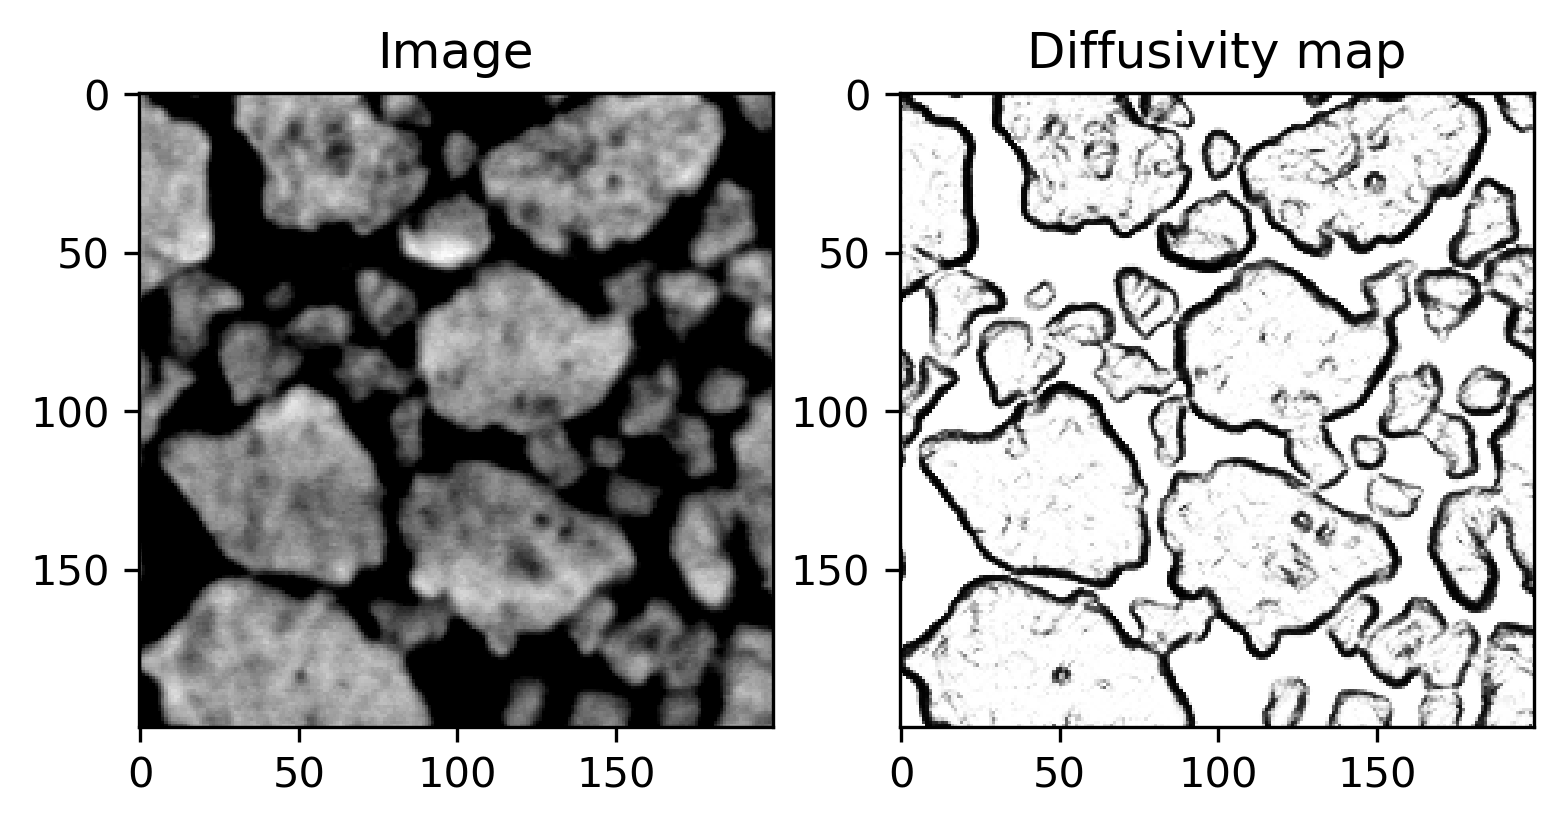

In [42]:
plt.subplot(1,2,1); plt.imshow(io.imread("figures/aggregates.png"),cmap='gray'); plt.title('Image');
plt.subplot(1,2,2); plt.imshow(io.imread("figures/diffusivity.png"),cmap='gray'); plt.title('Diffusivity map');

- _$u$_ Image to be filtered
- _$G(\cdot)$_ Non-linear function to control the diffusivity
- _$\tau$_ Time increment
- _$N$_ Number of iterations

<div class="alert alert-block alert-danger">
<center>This filter is noise sensitive!</center>
</div>

## The non-linear diffusion filter

A more robust filter is obtained with

$$\frac{\partial u}{\partial t}=G(|\nabla_{\sigma} u|)\nabla^2u$$

- _$u$_ Image to be filtered
- _$G(\cdot)$_ Non-linear function to control the contrast
- _$\tau$_ Time increment per numerical iteration
- _$N$_ Number of iterations
- _$\nabla_{\sigma}$_ Gradient smoothed by a Gaussian filter, width $\sigma$



## Diffusion filter example
Neutron CT slice from a real-time experiment observing the coalescence of cold mixed bitumen.

<table>    
    <tr>
        <td>Original</td><td>Iterations of non-linear diffusion</td>
    </tr>
    <tr>
        <td><img src="figures/bitumen.png" style="height:300px"></td>
        <td><video src="movies/nldif_iter.mp4" type="video/mp4" controls autoplay loop height="300px"></td>    
    </tr>
</table>


## Filtering as a regularization problem
### The continued development

- __90's__ During the late 90's the diffusion filter was described in terms of a regularization problem.
- __00's__ Work toward regularization of total variation minimization.

#### TV-L1
$$u=\underset{u\in BV(\Omega)}{\operatorname{argmin}}\left\{\underbrace{|u|_{BV}}_{noise}+ \underbrace{\mbox{$\frac{\lambda}{2}$}\|f-u\|_{1}}_{fidelity}\right\}$$
#### Rudin-Osher-Fatemi model (ROF)
$$u=\underset{u\in BV(\Omega)}{\operatorname{argmin}}
\left\{
\underbrace{|u|_{BV}}_{noise} 
+ \underbrace{\mbox{$\frac{\lambda}{2}$} \|f-u\|^2_{2}}_{fidelity}
\right\}$$

with $|u|_{BV}=\int_{\Omega}|\nabla u|^2$


## The inverse scale space filter
#### The idea 
We want smooth regions with sharp edges\ldots

- Turn the processing order of scale space filter upside down
- Start with an empty image
-  Add large structures successively until an image with relevant features appears

#### The ISS filter - Some properties
- is an edge preserving filter for noise reduction.
- is defined by a partial differential equation.
- has a well defined termination point.

[Burger et al. 2006](https://dx.doi.org/10.4310/CMS.2006.v4.n1.a7)

## The ROF filter equation
The image $f$ is filtered by solving

$\frac{\partial{}u}{\partial{}t}=\mathrm{div}\left(\frac{\nabla{}u}{|\nabla{}u|}\right)+\lambda{}(f-u+v)$

$\frac{\partial{}v}{\partial{}t}=\alpha{}(f-u)$

#### Variables:
- _$f$_ Input image
- _$u$_ Filtered image
- _$v$_ Regularization term (feedback of previous iteration)

#### Filter parameters
- _$\lambda$_ Related to the scale of the features to suppress.
- _$\alpha$_ Quality refinement
- _$N$_ Number of iterations
- _$\tau$_ Time increment


## Filter iterations
Neutron CT of dried lung filtered using 3D ISS filter

<table>    
    <tr><td>Original</td><td>Filter iterations</td></tr>
    <tr>
    <td><img src="figures/lung_iterations_first.png" style="height:300px"></td>   
    <td><video src="movies/filter_iterations.mp4" type="video/mp4" controls autoplay loop height="300px"></td>
    </tr>
</table>


## How to choose $\lambda$ and $\alpha$
The requirements varies between different data sets.

#### Initial conditions:
- Signal to noise ratio
- Image features (fine grained or wide spread)

#### Experiment:
- Scan $\lambda$ and $\alpha$
- Stop at $T=n\, \tau= \sigma$ use different $\tau$
- When does different effects occur, related to $\sigma$?

## Solutions at different times

nini



|1|30|60|100|200|500|999|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|![](figures/iss-iteration_0001.png) |![](figures/iss-iteration_0030.png) |![](figures/iss-iteration_0060.png) |![](figures/iss-iteration_0100.png) |![](figures/iss-iteration_0200.png) |![](figures/iss-iteration_0500.png) |![](figures/iss-iteration_0999.png) |

<img src="figures/iss-errorplot.svg" style="height:400px">

```{figure} figures/iss-errorplot.pdf
---
scale: 70%
---
Error plot for different solution times of the ISS filter.
```

## Solution time
The solution time ($T=N\cdot\tau$) is essential to the result
- _$\tau$ large_ The solution is reached fast
- _$\tau$ small_ The numerical accuracy is better

## The choice of initial image

```{figure} figures/iss-errorplots_initialimage.pdf
---
scale: 70%
---
Error plots depend on the choice of the initial image.
```

<img src="figures/iss-errorplots_initialimage.svg" style="height:400px">

At some $T$ the solution with $u_0=f$ and $u_0=0$ converge.

# Non-local means

## Non-local smoothing
### The idea
Smoothing normally consider information from the neighborhood like

- Local averages (convolution)
- Gradients and Curvatures (PDE filters)

Non-local smoothing average similiar intensities in a global sense.
- Every filtered pixel is a weighted average of all pixels.
- Weights computed using difference between pixel intensities.

[Buades et al. 2005](http://dx.doi.org/10.1137/040616024)


## Filter definition
The non-local means filter is defined as
$$u(p)=\frac{1}{C(p)}\sum_{q\in\Omega}v(q)\,f(p,q)$$
where
- _$v$ and $u$_ input and result images.
- _$C(p)$_ is the sum of all pixel weights as 

    $C(p)=\sum_{q\in\Omega}f(p,q)$
    
    
- _$f(p,q)$_ is the weighting function

    $f(p,q)=e^{-\frac{|B(q)-B(p)|^2}{h^2}}$
    
    
- _B(x)_ is a neighborhood operator e.g. local average around $x$

## Non-local means 2D - Example

```{figure} figures/nonlocal_example.png
---
scale: 100%
---
Demonstration on the non-local means filter.
```

<img src="figures/nonlocal_example.png" style="height:400px">

### Observations

- Good smoothing effect.
- Strong thin lines are preserved.
-  Some patchiness related to filter parameter $t$, *i.e.* the size of $\Omega_i$.

## Performance complications
### Problem
The orignal filter compares all pixels with all pixels\ldots\\
- Complexity $\mathcal{O}(N^2)$ 
- Not feasible for large images, and particular 3D images!

### Solution
It has been shown that not all pixels have to be compared to achieve a good filter effect.
i.e. $\Omega$ in the filter equations can be replaced by $\Omega_i<<\Omega$ 

# Verification
## How good is my filter?

## Verify the correctness of the method
#### "Data massage"
Filtering manipulates the data, avoid too strong modifications otherwise you may invent new image features!!!

```{figure} figures/mugs.png
---
scale: 60%
---
Be careful when you apply different filters. You may make to great modifications.
```

<center><img src="figures/mugs.png" style="height:250px"></center>

#### Verify the validity your method
- Visual inspection
- Difference images
- Use degraded phantom images in a "smoke test"

## Verification using difference images
Compute pixel-wise difference between image $f$ and $g$
<img src="figures/verification_differences.svg" style="height:600px">

Difference images provide first diagnosis about processing performance 

## Performance testing - The smoke test

- Testing term from electronic hardware testing - drive the system until something fails due to overheating...
- In general: scan the parameter space for different SNR until the method fails to identify strength and weakness of the system.

### Test strategy
1. Create a phantom image with relevant features.
2. Add noise for different SNR to the phantom.
3. Apply the processing method with different parameters.
4. Measure the difference between processed and phantom.
5. Repeat steps 2-4 $N$ times for better test statistics.
6. Plot the results and identify the range of SNR and parameters that produce acceptable results.

## Data for evaluation -  Phantom data
General purpose can be controlled
- Data with known features.
- Parameters can be changed.
    - Shape
    - Sharpness
    - Contrast
    - Noise (distribution and strength)
<table><tr>
<td><img src="figures/shepplogan.png" style="height:250px"</td>
<td><img src="figures/synthetic_root4.png" style="height:250px"</td>
    </tr></table>

```{figure} figures/shepplogan.png
---
scale: 50%
---
The  shepp logan phantom.
```

```{figure} figures/synthetic_root4.png
---
scale: 50%
---
A simulated root network.
```

## Data for evaluation - Labelled data
Often 'real' data
- Labeled by experts
- Used for training and validation
     - Training of model
     - Validation 
     - Test

<center><img src="figures/mnist.png" style="height:300px"></center>

```{figure} figures/mnist.png
---
scale: 75%
---
Images of hand written numbers from the MNIST data base.
```

## Evaluation metrics for images
An evaluation procedure need a metric to compare the performance
#### Mean squared error
<font size=5>
$$MSE(f,g)=\sum_{p\in \Omega}(f(p)-g(p))^2$$
</font>

#### Structural similarity index
<font size=5>
$$SSIM(f,g)=\frac{(2\mu_f\,\mu_g+C_1)(2\sigma_{fg}+C_2)}{(\mu_f^2+\mu_g^2+C_1)(\sigma_f^2+\sigma_g^2+C_2)}$$
    </font>
    
- _$\mu_f$, $\mu_g$_ Local mean of $f$ and $g$.
- _$\sigma_{fg}$_ Local correlation between $f$ and $g$.
- _$\sigma_f$, $\sigma_g$_ Local standard deviation of $f$ and $g$.
- _$C_1$, $C_2$_ Constants based on the image dynamics (small numbers).


<font size=5>
$$MSSIM(f,g)=E[SSIM(f,g)]$$
</font>

[Wang 2009](https://doi.org/10.1109/MSP.2008.930649)

## Test run example

Runnig tests with different structure sizes and SNR. 

### Phantom structure sizes
|1|2|4|8|
|:---:|:---:|:---:|:---:|
|![](figures/synthetic_root1.png)|![](figures/synthetic_root2.png)|![](figures/synthetic_root4.png)|![](figures/synthetic_root8.png)|


### Change SNR and contrast

| $\sigma$=1|$\sigma$=2|$\sigma$=5|$\sigma$=10|
|:---:|:---:|:---:|:---:|
|![](figures/noise01.png)|![](figures/noise02.png)|![](figures/noise05.png)|![](figures/noise10.png)|

#### Process

<div class="alert alert-block alert-success">
Apply processing sequence.
</div>

#### Plot results
| R=1|R=2|R=4|R=8|
|:---:|:---:|:---:|:---:|
|![](figures/radius1.png)|![](figures/radius2.png)|![](figures/radius4.png)|![](figures/radius8.png)|

[Kaestner et al. 2006](https://doi.org/10.1016/j.geoderma.2006.04.009)

# Overview

## Many filters

```{figure} figures/filter_overview_gray.pdf
---
scale: 100%
---
All filters form the lecture for different SNR.
```

<img src="figures/filter_overview_gray.svg" style="height:600px">

## Details of filter performance

```{figure} figures/filter_overview_close_gray.pdf
---
scale: 100%
---
A close-up of all filters form the lecture for different SNR.
```

<img src="figures/filter_overview_close_gray.svg" style="height:600px">

## Take-home message
We have looked at different ways to suppress noise and artifacts:

- Convolution 
- Median filters
- Wavelet denoising
- PDE filters

Which one you select depends on 
- Purpose of the data
- Quality requirements 
- Available time
<div class="alert alert-block alert-success">
<b>Remember</b>: A good measurement is better than an enhanced bad measurement, but bad data can mostly be rescued if needed.
</div>

